In [1]:
from six.moves import cPickle
import os
import matplotlib.pyplot as plt
import numpy as np
import importlib
import utils as ut
import functions as fu

Using TensorFlow backend.


# Explore cifar-10 dataset 

(10000, 32, 32, 3)
D:\Logiciel\anaconda\envs\tf-keras-gpu\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


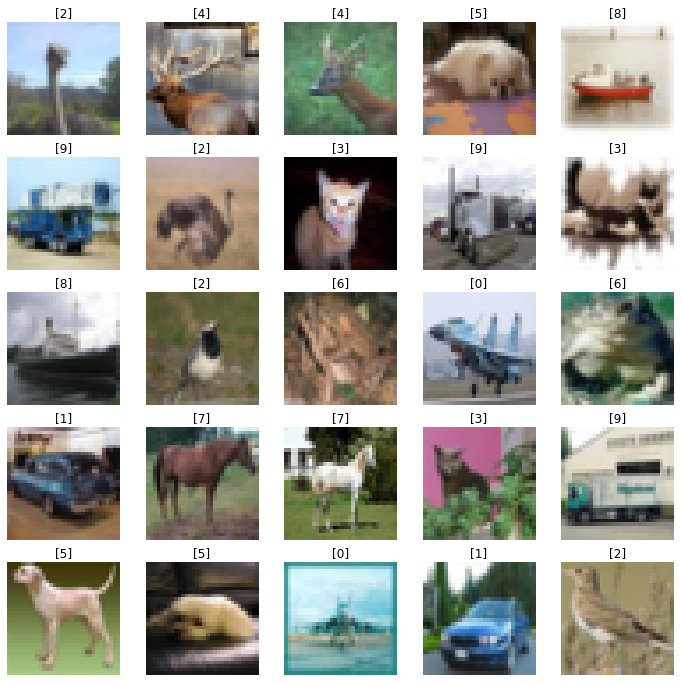

In [2]:
importlib.reload(ut)
X, y, _ = ut.loadData('data_batch_1', reshape=True, clipping=False)
ut.plotCifar(X, y)

# Exercise 1: Trianing a multi-linear classifier

## Data Preprocessing and Loading 

In [3]:
K, d, n = 10, 3072, 10000
_lambda = 1e-2

In [2]:
importlib.reload(ut)
X_train, y_train, Y_train = ut.loadData('data_batch_1', clipping=True)
X_val, y_val, Y_val = ut.loadData('data_batch_2', clipping=True)
X_test, y_test, Y_test = ut.loadData('data_batch_3', clipping=True)

## normalize with mean and std of train set 
mean_X = np.mean(X_train, axis=1)
std_X = np.std(X_train, axis=1)

X_train -= np.outer(mean_X, np.ones(X_train.shape[1]))
X_train /= np.outer(std_X, np.ones(X_train.shape[1]))

X_val -= np.outer(mean_X, np.ones(X_val.shape[1]))
X_val /= np.outer(std_X, np.ones(X_val.shape[1]))

X_test -= np.outer(mean_X, np.ones(X_test.shape[1]))
X_test /= np.outer(std_X, np.ones(X_test.shape[1]))

In [5]:
X_train.shape

(3072, 10000)

In [6]:
Y_train.shape

(10, 10000)

In [7]:
mean_X.shape

(3072,)

## Initialize 

In [8]:
mu, sigma = 0, 0.01 
np.random.seed(42)
W = np.random.normal(mu, sigma, (K,d))
b = np.random.normal(mu, sigma, (K,1))
b

array([[ 0.01412668],
       [-0.00221371],
       [-0.01130804],
       [ 0.00509068],
       [-0.00391057],
       [-0.00207101],
       [ 0.00144906],
       [-0.00812213],
       [-0.01621136],
       [-0.0005127 ]])

In [9]:
importlib.reload(ut)
P = ut.EvaluateClassifier(X_train[:, :100], W, b)
print(P.shape)
print(np.argmax(P, axis=0))

(10, 100)
[1 9 3 1 2 3 6 8 6 3 1 5 2 1 1 1 6 1 4 1 0 9 1 7 7 2 7 3 7 6 9 7 9 0 4 7 5
 3 5 1 5 5 4 5 3 1 1 9 4 0 7 3 9 0 3 6 3 1 1 2 3 3 3 1 0 2 1 3 1 5 8 2 1 3
 6 1 7 1 1 4 5 8 1 3 5 1 9 9 3 2 7 1 2 1 3 5 1 7 1 6]


In [10]:
np.sum(np.multiply(Y_train[:,:100], P), axis=0).shape

(100,)

In [11]:
importlib.reload(ut)
cost = ut.ComputeCost(X_train[:,:100], Y_train[:, :100], W , b, 1e-2)
cost

2.4472468461982277

In [12]:
acc = ut.ComputeAccuracy(X_train[:, :100], y_train[:100], W, b)
acc

0.09

In [37]:
batch_start, batch_end=0, 20

In [38]:
importlib.reload(ut)
_lambda = 1e-2
P = ut.EvaluateClassifier(X_train[:, batch_start:batch_end], W, b)
ga_w, ga_b = ut.ComputeGradients(X_train[:, batch_start:batch_end], Y_train[:, batch_start:batch_end], P, W, _lambda)
print(ga_w.shape, ga_b.shape)

(10, 3072) (10,)


In [39]:
importlib.reload(fu)
gn_w, gn_b = fu.ComputeGradsNumSlow(X_train[:, batch_start:batch_end], Y_train[:, batch_start:batch_end], W, b, _lambda, 1e-6)

In [40]:
np.mean(gn_w - ga_w)

1.442631740432578e-12

In [41]:
importlib.reload(ut)
np.mean(ut.compare_gradients(ga_w, gn_w, eps=1e-4))

8.883013065110458e-09

In [42]:
np.mean(ut.compare_gradients(ga_b.reshape(-1,1), gn_b.reshape(-1,1), eps=1e-4))

1.0507729267193834e-08

## MiniBatch Train

In [10]:
importlib.reload(ut)

K, d, n = 10, 3072, 10000
_lambda = 1e-2

mu, sigma = 0, 0.01 
np.random.seed(42)
W = np.random.normal(mu, sigma, (K,d))
b = np.random.normal(mu, sigma, (K,1))

GDparams = {"batch_size":100, "epochs":40, "eta":1e-3}

W, b, train_loss, val_loss = ut.minibatchGD(X_train, Y_train, y_train,  X_val, Y_val, y_val, GDparams, W, b, _lambda=0, seed=42)

100%|██████████| 40/40 [02:08<00:00,  3.22s/it]Epoch 39: train_acc=0.4544 | val_acc=0.3824 | train_loss=1.6131483084049132 | val_loss=1.7931119223848828



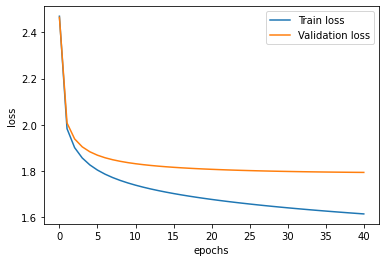

In [35]:
ut.plot_loss(train_loss, val_loss, 100, 40, 1e-3, 0)

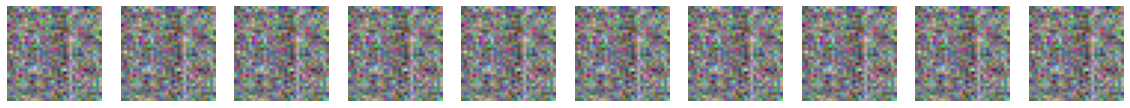

In [33]:
importlib.reload(ut)
ut.plot_weights(W, 100, 40, 1e-3, 0)

In [ ]:
lambdas = [0, .1, 1]
eta